In [485]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

In [486]:
# Load data
df = pd.read_csv('data.csv')

In [487]:
df.head()

,AMC,Fund Name,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk
0,mahindra manulife mutual fund,Mahindra Manulife Large & Mid Cap Reg-G,3,3,5.51%,28.32,37.79%,20.29%,Rs.500.0,Abhinav Khandelwal,2569.63 cr,Equity,High
1,mahindra manulife mutual fund,Mahindra Manulife Consumption Reg-G,0,3,7.25%,24.89,46.08%,21.93%,Rs.500.0,Abhinav Khandelwal,322.26 cr,Equity,High
2,mahindra manulife mutual fund,Mahindra Manulife Mid Cap Reg-G,4,4,5.94%,35.11,54.46%,27.48%,Rs.500.0,Abhinav Khandelwal,3292.76 cr,Equity,High
3,mahindra manulife mutual fund,Mahindra Manulife Small Cap Reg-G,0,0,8.37%,21.40,59.79%,0,Rs.500.0,Abhinav Khandelwal,5278.7 cr,Equity,Very High
4,mahindra manulife mutual fund,Mahindra Manulife Large Cap Reg-G,4,3,4.06%,23.69,32.07%,15.18%,Rs.500.0,Abhinav Khandelwal,577.72 cr,Equity,Very High


In [488]:
df['Fund Name'].unique()

array(['Mahindra Manulife Large & Mid Cap Reg-G',
       'Mahindra Manulife Consumption Reg-G',
       'Mahindra Manulife Mid Cap Reg-G', ...,
       'LIC MF Large & Mid Cap Reg-G', 'LIC MF Infrastructure-G',
       'LIC MF Balanced Advantage Reg-G'], dtype=object)

In [489]:
df.describe()

,Morning star rating,Value Research rating,NAV
count,1393.000000,1393.000000,1393.000000
mean,1.666906,1.669060,321.144436
std,1.792674,1.730066,856.937370
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,15.260000
50%,1.000000,1.000000,28.890000
75%,3.000000,3.000000,101.320000
max,5.000000,5.000000,6706.890000


In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AMC                    1393 non-null   object 
 1   Fund Name              1393 non-null   object 
 2   Morning star rating    1393 non-null   int64  
 3   Value Research rating  1393 non-null   int64  
 4   1 month return         1393 non-null   object 
 5   NAV                    1393 non-null   float64
 6   1 Year return          1393 non-null   object 
 7   3 Year Return          1393 non-null   object 
 8   Minimum investment     1393 non-null   object 
 9   Fund Manager           1354 non-null   object 
 10  AUM                    1393 non-null   object 
 11  Category               1393 non-null   object 
 12  Risk                   1393 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 141.6+ KB


# data clean

In [491]:
# Remove '%' and convert to float
df['1 month return'] = df['1 month return'].str.rstrip('%').astype(float)

In [492]:

df['1 Year return'] = df['1 Year return'].str.rstrip('%').astype(float)

In [493]:
df['3 Year Return'] = df['3 Year Return'].str.rstrip('%').astype(float)

In [494]:
# Remove 'Rs.' from Minimum investment and convert to float
df['Minimum investment'] = df['Minimum investment'].str.replace('Rs.', '').astype(float)


In [495]:
# Remove 'cr' from AUM and handle non-numeric values
df['AUM'] = df['AUM'].str.replace('cr', '').replace('', None)
df['AUM'] = pd.to_numeric(df['AUM'], errors='coerce')

In [496]:
# Replace 0s in Morning star rating and Value Research rating with the mode
for column in ['Morning star rating', 'Value Research rating']:
    # Calculate the mode values based on groupby
    mode_values = df.groupby(['Fund Name', 'Category'])[column].agg(lambda x: x.mode()[0] if not x.mode().empty else 0)

    # Create a function to apply the mode replacement
    def replace_zeros(row):
        if row[column] == 0:
            return mode_values.get((row['Fund Name'], row['Category']), 0)
        return row[column]

    # Apply the function to the DataFrame
    df[column] = df.apply(replace_zeros, axis=1)

In [497]:
# Convert Minimum investment to int
df['Minimum investment'] = df['Minimum investment'].astype(int)

In [498]:
mean_returns = df[df['1 Year return'] != 0].groupby(['AMC', 'Category'])['1 Year return'].mean().reset_index()

# Use the mean to fill in the 0 values in a new DataFrame
df1 = df.copy()
for index, row in mean_returns.iterrows():
    fund_name = row['AMC']
    category = row['Category']
    mean_value = row['1 Year return']
    df1.loc[(df1['AMC'] == fund_name) & (df1['Category'] == category) & (df1['1 Year return'] == 0), '1 Year return'] = mean_value


In [499]:
mean_returns = df[df['3 Year Return'] != 0].groupby(['AMC', 'Category'])['3 Year Return'].mean().reset_index()

# Use the mean to fill in the 0 values in a new DataFrame
df1 = df.copy()
for index, row in mean_returns.iterrows():
    fund_name = row['AMC']
    category = row['Category']
    mean_value = row['3 Year Return']
    df1.loc[(df1['AMC'] == fund_name) & (df1['Category'] == category) & (df1['3 Year Return'] == 0), '3 Year Return'] = mean_value


In [500]:
mean_returns = df[df['1 month return'] != 0].groupby(['AMC', 'Category'])['1 month return'].mean().reset_index()

# Use the mean to fill in the 0 values in a new DataFrame
df1 = df.copy()
for index, row in mean_returns.iterrows():
    fund_name = row['AMC']
    category = row['Category']
    mean_value = row['1 month return']
    df1.loc[(df1['AMC'] == fund_name) & (df1['Category'] == category) & (df1['1 month return'] == 0), '1 month return'] = mean_value


In [501]:
# Calculate mean for 'Morning star rating' grouped by 'Fund Manager', ignoring 0 values
mean_ratings = df[df['Value Research rating'] != 0].groupby('Fund Manager')['Value Research rating'].mean()

# Create a new DataFrame to hold the results
df1 = df.copy()

# Replace 0 values in 'Morning star rating' with the corresponding mean
for fund_manager in mean_ratings.index:
    mean_value = int(mean_ratings[fund_manager])  # Convert mean to integer
    df1.loc[(df1['Fund Manager'] == fund_manager) & (df1['Value Research rating'] == 0), 'Value Research rating'] = mean_value



In [502]:
# Calculate mean for 'Morning star rating' grouped by 'Fund Manager', ignoring 0 values
mean_ratings = df[df['Morning star rating'] != 0].groupby('Fund Manager')['Morning star rating'].mean()

# Create a new DataFrame to hold the results
df1 = df.copy()

# Replace 0 values in 'Morning star rating' with the corresponding mean
for fund_manager in mean_ratings.index:
    mean_value = int(mean_ratings[fund_manager])  # Convert mean to integer
    df1.loc[(df1['Fund Manager'] == fund_manager) & (df1['Morning star rating'] == 0), 'Morning star rating'] = mean_value


In [503]:
df['Morning star rating'] = df['Morning star rating'].replace(0, np.nan).fillna(method='ffill')
df['Value Research rating'] = df['Value Research rating'].replace(0, np.nan).fillna(method='ffill')

# Check the result to see if replacement was successful
print(df[['Fund Name', 'Category', 'Morning star rating', 'Value Research rating']])

                                    Fund Name Category  Morning star rating  \
0     Mahindra Manulife Large & Mid Cap Reg-G   Equity                  3.0   
1         Mahindra Manulife Consumption Reg-G   Equity                  3.0   
2             Mahindra Manulife Mid Cap Reg-G   Equity                  4.0   
3           Mahindra Manulife Small Cap Reg-G   Equity                  4.0   
4           Mahindra Manulife Large Cap Reg-G   Equity                  4.0   
...                                       ...      ...                  ...   
1388                   LIC MF Multi Cap Reg-G   Equity                  4.0   
1389                       LIC MF Large Cap-G   Equity                  2.0   
1390             LIC MF Large & Mid Cap Reg-G   Equity                  2.0   
1391                  LIC MF Infrastructure-G   Equity                  3.0   
1392          LIC MF Balanced Advantage Reg-G   Hybrid                  3.0   

      Value Research rating  
0                    

C:\Users\Milan Nagvadiya\AppData\Local\Temp\ipykernel_10980\1497933585.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Morning star rating'] = df['Morning star rating'].replace(0, np.nan).fillna(method='ffill')
C:\Users\Milan Nagvadiya\AppData\Local\Temp\ipykernel_10980\1497933585.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Value Research rating'] = df['Value Research rating'].replace(0, np.nan).fillna(method='ffill')


In [504]:
df1.head()

,AMC,Fund Name,Morning star rating,Value Research rating,1 month return,NAV,1 Year return,3 Year Return,Minimum investment,Fund Manager,AUM,Category,Risk
0,mahindra manulife mutual fund,Mahindra Manulife Large & Mid Cap Reg-G,3,3,5.51,28.32,37.79,20.29,500,Abhinav Khandelwal,2569.63,Equity,High
1,mahindra manulife mutual fund,Mahindra Manulife Consumption Reg-G,3,3,7.25,24.89,46.08,21.93,500,Abhinav Khandelwal,322.26,Equity,High
2,mahindra manulife mutual fund,Mahindra Manulife Mid Cap Reg-G,4,4,5.94,35.11,54.46,27.48,500,Abhinav Khandelwal,3292.76,Equity,High
3,mahindra manulife mutual fund,Mahindra Manulife Small Cap Reg-G,3,0,8.37,21.40,59.79,0.00,500,Abhinav Khandelwal,5278.70,Equity,Very High
4,mahindra manulife mutual fund,Mahindra Manulife Large Cap Reg-G,4,3,4.06,23.69,32.07,15.18,500,Abhinav Khandelwal,577.72,Equity,Very High


In [505]:
data=pd.DataFrame(df1)

In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AMC                    1393 non-null   object 
 1   Fund Name              1393 non-null   object 
 2   Morning star rating    1393 non-null   int64  
 3   Value Research rating  1393 non-null   int64  
 4   1 month return         1393 non-null   float64
 5   NAV                    1393 non-null   float64
 6   1 Year return          1393 non-null   float64
 7   3 Year Return          1393 non-null   float64
 8   Minimum investment     1393 non-null   int64  
 9   Fund Manager           1354 non-null   object 
 10  AUM                    1383 non-null   float64
 11  Category               1393 non-null   object 
 12  Risk                   1393 non-null   object 
dtypes: float64(5), int64(3), object(5)
memory usage: 141.6+ KB


# EDA

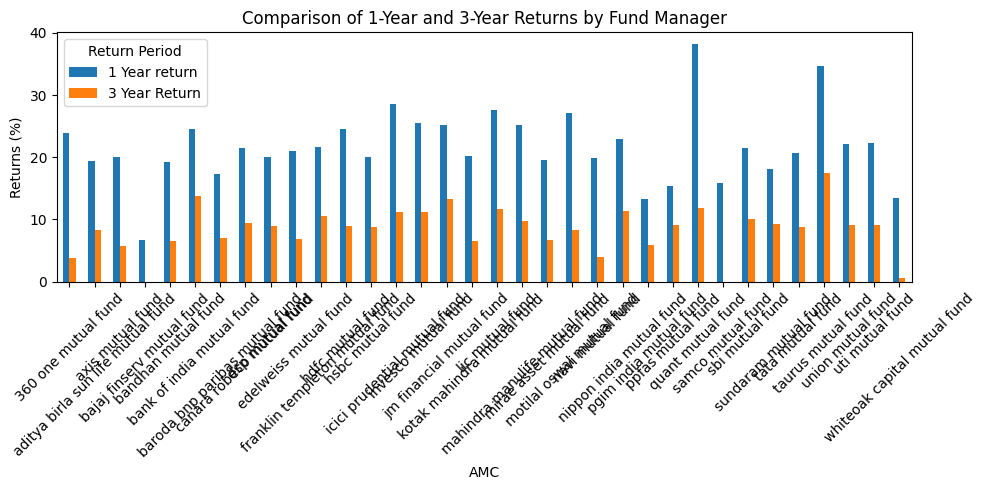

In [513]:
mean_returns = df.groupby('AMC')[['1 Year return', '3 Year Return']].mean().reset_index()

# Set the Fund Manager as index for better plotting
mean_returns.set_index('AMC', inplace=True)

# Plot the comparison
mean_returns.plot(kind='bar', figsize=(10, 5))
plt.title('Comparison of 1-Year and 3-Year Returns by Fund Manager')
plt.ylabel('Returns (%)')
plt.xticks(rotation=45)
plt.legend(title='Return Period')
plt.tight_layout()
plt.show()

In [515]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['NAV'], y=df['1 Year return'], hue=df['Risk'], palette='viridis')
plt.title('NAV vs 1 Year Return by Risk Level')
plt.xlabel('Net Asset Value (NAV)')
plt.ylabel('1 Year Return (%)')
plt.show()


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [511]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt


# Define numerical and categorical columns
numerical_cols = [
    'Morning star rating',   
    'Value Research rating',
    '1 month return',
    'NAV',
    '1 Year return',
    'Minimum investment',
    'AUM'
]

categorical_cols = [
    'AMC',
    'Fund Name',
    'Fund Manager',
    'Category',
    'Risk'
]

# Handle missing values with imputation
numerical_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])


X = data.drop('3 Year Return', axis=1)
y = data['3 Year Return']

Running RandomizedSearchCV for Linear Regression...
Running RandomizedSearchCV for Lasso Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters from RandomizedSearchCV: {'model__alpha': np.float64(0.6808361216819946)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running RandomizedSearchCV for Ridge Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters from RandomizedSearchCV: {'model__alpha': np.float64(7.900932022121825)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 fold

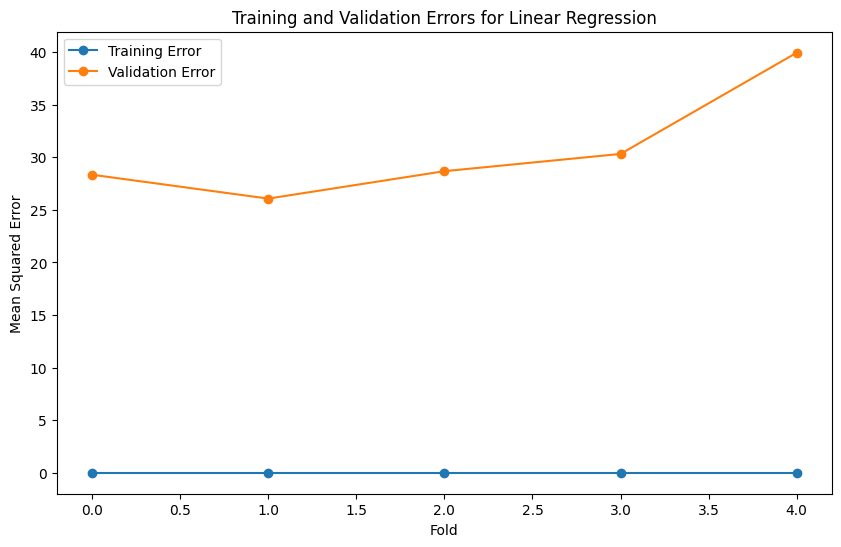

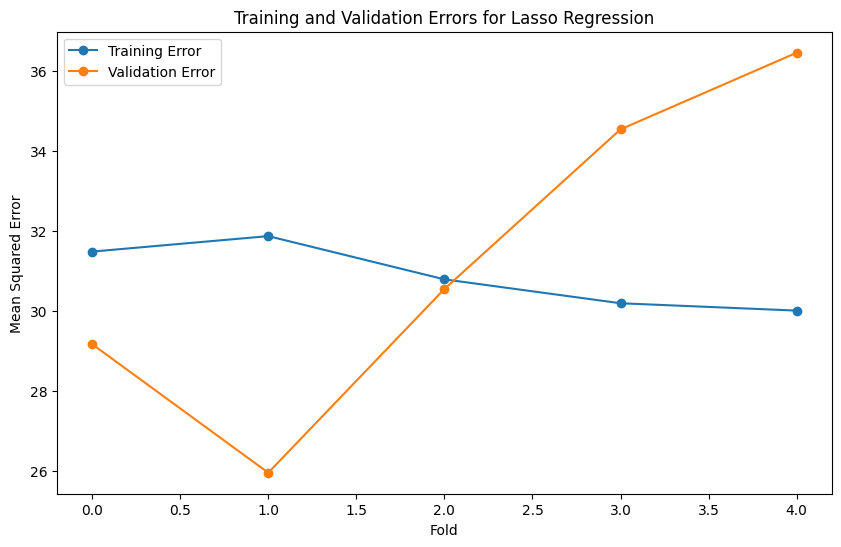

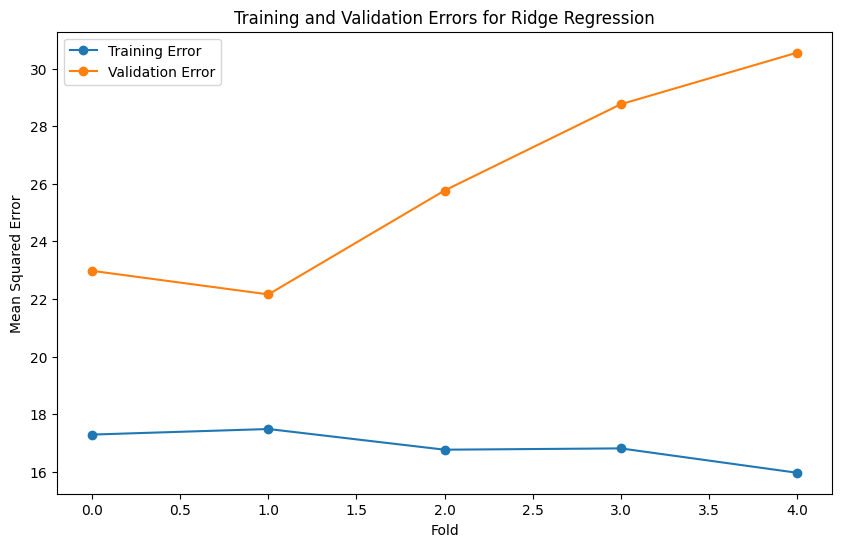

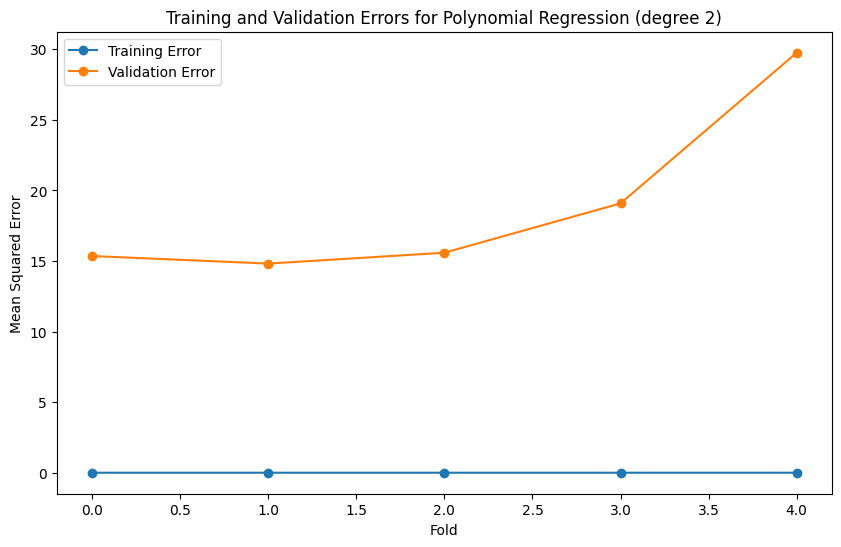

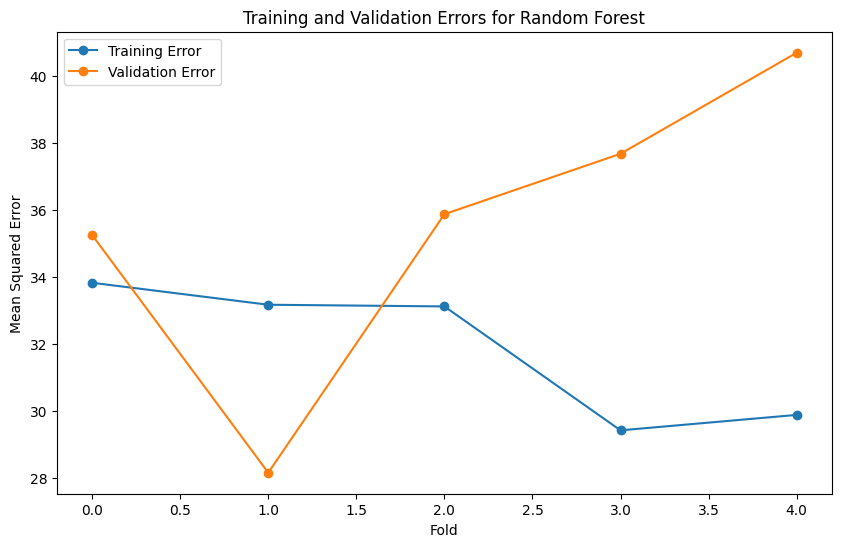

In [512]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Function to create a pipeline with Standard Scaler
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', ColumnTransformer(transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])),
        ('model', model)
    ])

# Polynomial Regression (degree 2) requires PolynomialFeatures before the linear model
def create_polynomial_pipeline(degree, model):
    return Pipeline(steps=[
        ('preprocessor', ColumnTransformer(transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])),
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('model', model)
    ])

# Define pipelines
pipelines = {
    'Linear Regression': create_pipeline(LinearRegression()),
    'Lasso Regression': create_pipeline(Lasso(random_state=42)),
    'Ridge Regression': create_pipeline(Ridge(random_state=42)),
    'Polynomial Regression (degree 2)': create_polynomial_pipeline(2, LinearRegression()),
    'Random Forest': create_pipeline(RandomForestRegressor(random_state=42))
}

# Define parameter distributions
def create_param_dist(params):
    return {f'model__{key}': value for key, value in params.items()}

param_dist = {
    'Linear Regression': create_param_dist({}),  # No hyperparameters
    'Lasso Regression': create_param_dist({'alpha': uniform(0.1, 10)}),
    'Ridge Regression': create_param_dist({'alpha': uniform(0.1, 50)}),
    'Polynomial Regression (degree 2)': create_param_dist({}),  # No hyperparameters
    'Random Forest': {
        'model__n_estimators': randint(50, 200),
        'model__max_depth': randint(10, 50),
        'model__min_samples_split': randint(2, 11),
        'model__min_samples_leaf': randint(1, 5),
        'model__max_features': ['sqrt', 'log2'],
        'model__bootstrap': [True, False]
    }
}

kf = KFold(n_splits=5)

# Function to collect training and validation errors
def collect_errors(pipeline, X, y, kf):
    train_errors = []
    val_errors = []
    
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict and calculate errors
        y_train_pred = pipeline.predict(X_train_fold)
        y_val_pred = pipeline.predict(X_val_fold)
        
        train_errors.append(mean_squared_error(y_train_fold, y_train_pred))
        val_errors.append(mean_squared_error(y_val_fold, y_val_pred))
    
    return train_errors, val_errors

# Model selection and evaluation
results = {}
errors = {}

for name, pipeline in pipelines.items():
    print(f"Running RandomizedSearchCV for {name}...")
    
    # Check if there are hyperparameters to tune
    if param_dist[name]:
        # Perform Randomized Search
        randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_dist[name], 
                                               n_iter=10, cv=kf, verbose=2, random_state=42, n_jobs=-1)
        randomized_search.fit(X, y)  # Use the full dataset for fitting
        
        # Save the best parameters from RandomizedSearchCV
        best_params_randomized = randomized_search.best_params_
        print(f"Best parameters from RandomizedSearchCV: {best_params_randomized}")

        # Extract the best parameters for GridSearchCV
        param_grid = {key: [best_params_randomized[key]] for key in best_params_randomized}
        
        # Perform Grid Search
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
        grid_search.fit(X, y)  # Use the full dataset for fitting

        # Use grid_search for further evaluation
        best_estimator = grid_search
    else:
        # Fit the model directly
        pipeline.fit(X, y)
        best_estimator = pipeline

    # Collect training and validation errors
    train_errors, val_errors = collect_errors(best_estimator, X, y, kf)
    errors[name] = {'train': train_errors, 'val': val_errors}

    # Evaluate on training set
    y_train_pred = best_estimator.predict(X)
    train_mse = mean_squared_error(y, y_train_pred)
    train_r2 = r2_score(y, y_train_pred)
    train_mae = mean_absolute_error(y, y_train_pred)

    # Collect results
    results[name] = {
        'best_params_randomized': best_params_randomized if param_dist[name] else None,
        'best_params_grid': grid_search.best_params_ if param_dist[name] else None,
        'train_mse': train_mse,
        'train_r2': train_r2,
        'train_mae': train_mae
    }

# Display results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"  Best Parameters from Randomized Search: {result['best_params_randomized']}")
    print(f"  Best Parameters from Grid Search: {result['best_params_grid']}")
    print(f"  Training MAE: {result['train_mae']}")
    print(f"  Training MSE: {result['train_mse']}")
    print(f"  Training R^2: {result['train_r2']}")
    print("\n")

# Plot training and validation errors
for name, errs in errors.items():
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(errs['train'])), errs['train'], label='Training Error', marker='o')
    plt.plot(range(len(errs['val'])), errs['val'], label='Validation Error', marker='o')
    plt.title(f'Training and Validation Errors for {name}')
    plt.xlabel('Fold')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()


# Best Model
Model: Polynomial Regression (degree 2)


  Best Parameters from Randomized Search: None

  Best Parameters from Grid Search: None

  Training MAE: 0.6253638529762775


  Training MSE: 5.937735491846271

  Training R^2: 0.9225345009105734
  
